C:\Users\ethan\AppData\Local\Temp\ipykernel_28544\1000551668.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


stroke
0    4861
1     249
Name: count, dtype: int64
0.9520054850874186
0.9506342132327734
0.951319849160096
0.9502913952691121
0.951319849160096


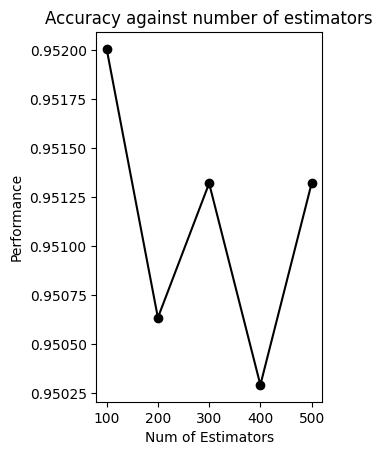

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9475385745775166
0.9533767569420638
Confusion Matrix:
 [[1392   65]
 [  71 1389]]


In [13]:
import pandas as pd

data = pd.read_csv('strokeData.csv')

#check for null 
data.isnull().sum()

"""fill missing values for bmi using median as more accurate, as mean skewed
by extreme data and mode can be skewed by outliers
"""
data['bmi'].fillna(data['bmi'].median(), inplace=True)
data.head()

#count how many stroke and non stroke for class balance
strokes = data['stroke'].value_counts()
print(strokes)

'''
as the class imbalance is huge SMOTE is needed to artificially balance it out
'''
#drop non essential data that would be used to predict stroke, use new data frame
dataFiltered = data.copy()
#stroke dropped as we are predicting and id is identifier and no related
dataFiltered.drop(['id'],axis=1,inplace=True)
'''encode the data as categorical data is not allowed in machine learning
hot encoding as no order or hierarchy
'''
dataFiltered = pd.get_dummies(dataFiltered, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

#correlation test to see what to drop
dataFiltered.corr()

#target and input data
predictors = dataFiltered.drop(columns=['stroke','gender_Female','gender_Male','gender_Other','Residence_type_Rural','Residence_type_Urban','smoking_status_Unknown','smoking_status_formerly smoked','smoking_status_never smoked','smoking_status_smokes','smoking_status_smokes'])
target = dataFiltered['stroke']

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.linear_model  import LinearRegression # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore

#SMOTE data
smote = SMOTE(random_state=42)
X_resampled,y_resampled = smote.fit_resample(predictors,target)


#split data into test and train data
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)


#using classifir as its for 1 and 0s, as if they have discrete labels or classes
from sklearn.ensemble import RandomForestClassifier # type: ignore
#importing accuracy_score to see how many of it matches
from sklearn.metrics import accuracy_score # type: ignore

'''
Creating a loop to adjust parameters of RandomForestClassifier to get a even better score
'''
n_estimatorsList = []
accuracyList = []

#declaring model and training model
#have to add one to include 500
for i in range(100,501,100):
    rf = RandomForestClassifier(i,class_weight='balanced')
    rf.fit(X_train,y_train)
    #predicting
    y_pred = rf.predict(X_test)
    #storing accuracy and r^2 valued
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    #append to list
    n_estimatorsList.append(i)
    accuracyList.append(accuracy)

#plot graph
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

plt.subplot(1,2,1)
plt.plot(n_estimatorsList,accuracyList, label='Accuracy',marker='o',color = 'black')
plt.title('Accuracy against number of estimators')
plt.xlabel('Num of Estimators')
plt.ylabel('Performance')
plt.show()


#using hyper parameters - gridSearchcv for best resutls
from sklearn.model_selection import GridSearchCV # type: ignore

param_grid = {
    'n_estimators' : [100,200,300,400,500],
    'max_depth': [None,10,20,30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
}


#fit model using gridsearch
#cv = cross validation, spliting data into training and validation sets multiple times in diff ways
#verbose - level of feedback
grid = GridSearchCV(estimator=rf, param_grid=param_grid,cv=5,scoring='accuracy', n_jobs=-1,verbose=1)

grid.fit(X_train,y_train)

print(grid.best_params_)
best_params = grid.best_params_
best_score = grid.best_score_
print("Best Cross-Validation Accuracy:", best_score)

#implementing a better forest model using those best parameters
optimizedRf = RandomForestClassifier(**best_params,class_weight='balanced',random_state=42)

#training model
optimizedRf.fit(X_train,y_train)

#prediciting model
y_prediction = optimizedRf.predict(X_test)
optimizedAccuracy = accuracy_score(y_test, y_prediction)

print(optimizedAccuracy)



Confusion Matrix:
 [[1392   65]
 [  71 1389]]


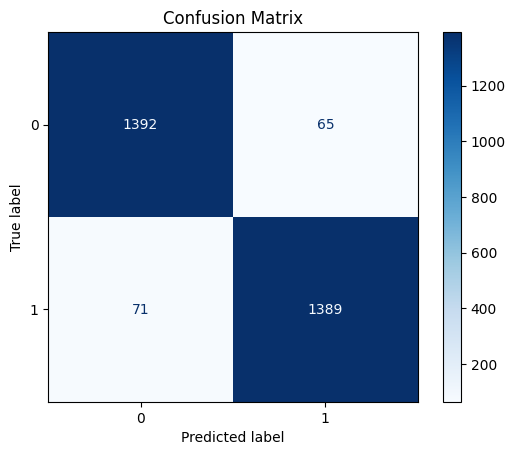

In [29]:
#using confusion matrix to inprove readability of model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn import metrics

# Confusion Matrix
cm = confusion_matrix(y_test, y_prediction)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
